In [1]:
%run ../nn_option_pricer/_key_imports.py

import sys

sys.path.append("../")
from nn_option_pricer.nn_archi import *
from nn_option_pricer.bachelier import *
from nn_option_pricer.utils import plot_loss, trainable_params
%run ../nn_option_pricer/default_config.py

In [2]:
X_df_train = pd.read_csv("datasets/bachelier_train.csv")

N_ASSETS = len([x for x in X_df_train.columns if x.find("asset_") == 0])
N_FEATS = N_ASSETS
feat_names = list(X_df_train.columns[:N_ASSETS])
f_to_i = lambda x: feat_names.index(x)


Xs_train = X_df_train.iloc[:, :N_ASSETS].values.astype(np.float32)
ys_train = X_df_train["call_payoff"].values.astype(np.float32)
grads_train = X_df_train.iloc[:, N_ASSETS : (2 * N_ASSETS)].values.astype(np.float32)

X_df_test = pd.read_csv("datasets/bachelier_test.csv")
Xs_test = X_df_test.iloc[:, :N_ASSETS].values.astype(np.float32)
ys_test = X_df_test["call_payoff"].values.astype(np.float32)
grads_test = X_df_test.iloc[:, N_ASSETS : (2 * N_ASSETS)].values.astype(np.float32)


X_tensor = tf.Variable(Xs_test)

all_model_preds = {}
all_model_grads = {}
all_model_hessian = {}
all_models = {}

intrinsic_val = (np.maximum(X_df_test["basket"] - 1.0, 0)
)
upper_bound = None
all_res = []

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [4]:
# """
# Neural Network Hyperparameters
# """
# HIDDEN_UNITS = 512
# LAYERS = 1
# dropout_ratio = 0.0
# HIDDEN_ACT = "softplus"

# OUTPUT_ACT = None
# DROPOUT_RATIO = 0.0
LR = 1e-4
nn_params["n_feats"] = N_FEATS
# BATCH_SIZE = 32
# EPOCHS = 30
# BATCH_NORM = False
loss_weights = (ys_train > 0)

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

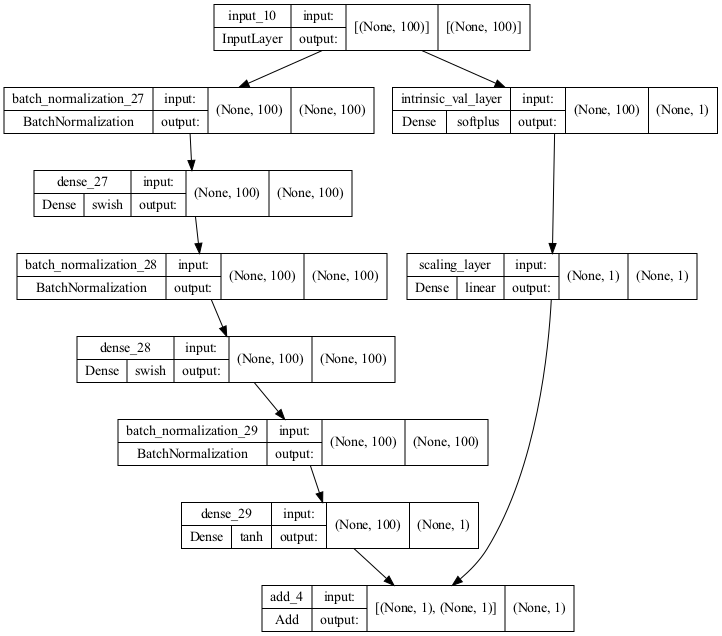

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

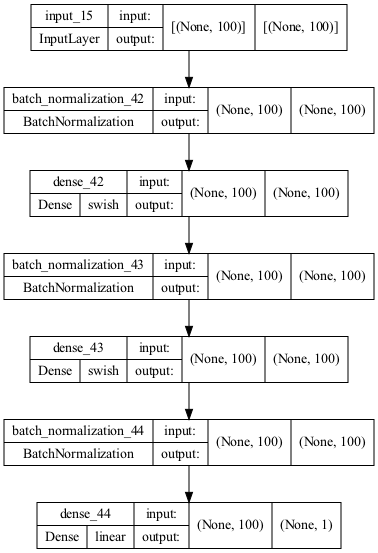

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

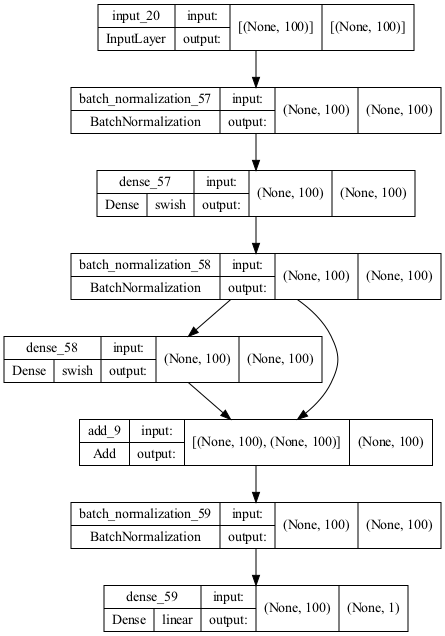

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

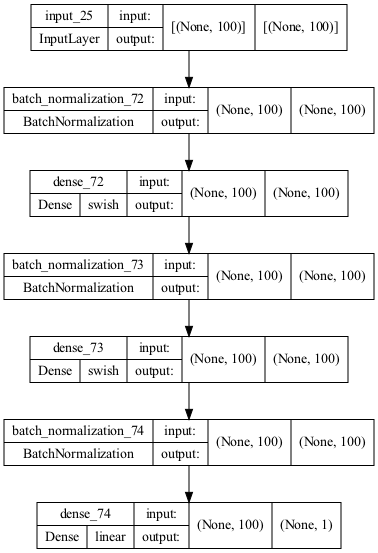

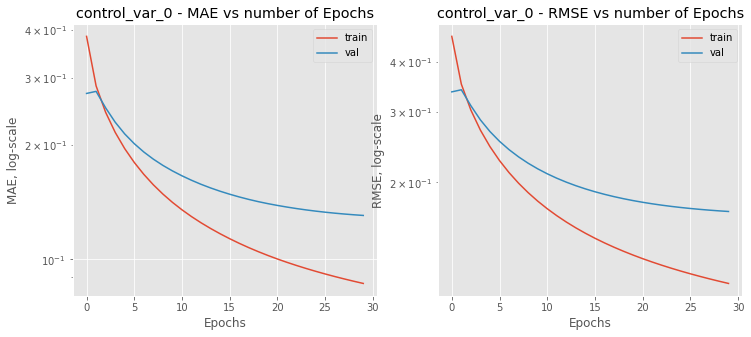

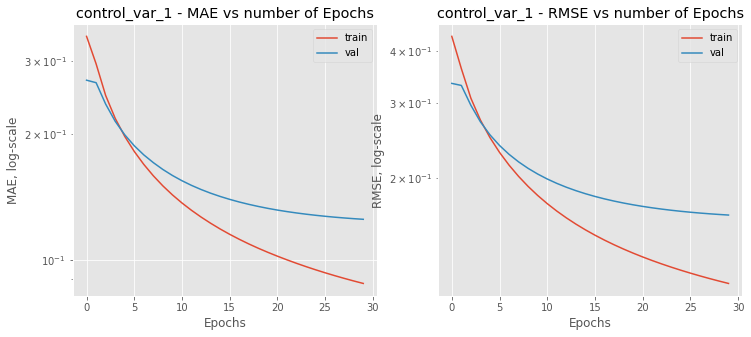

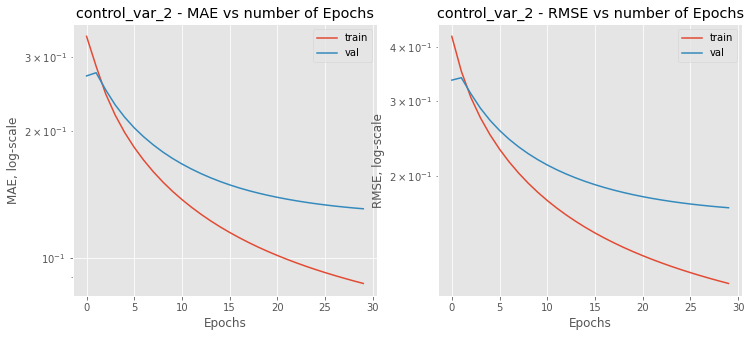

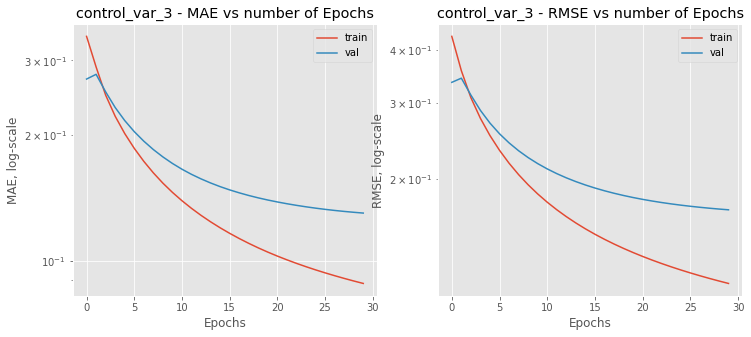

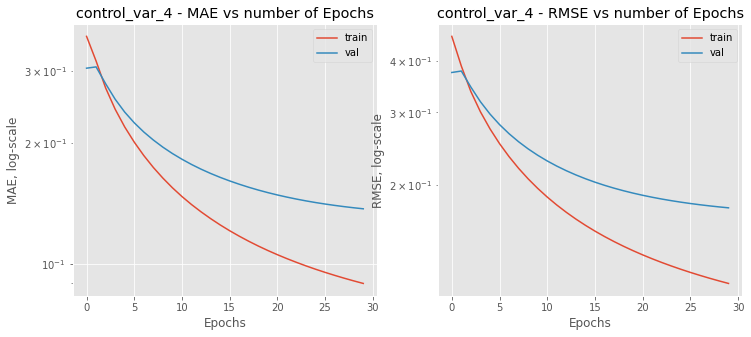

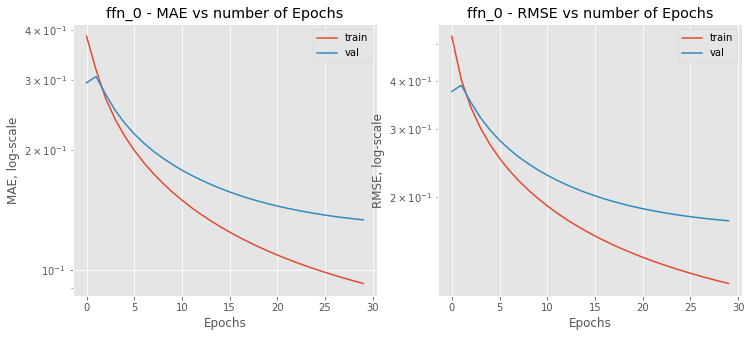

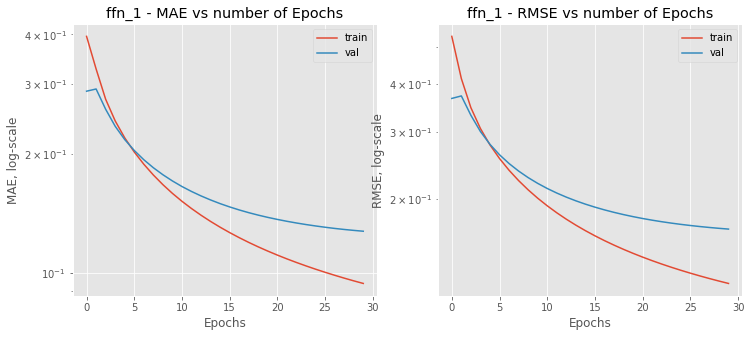

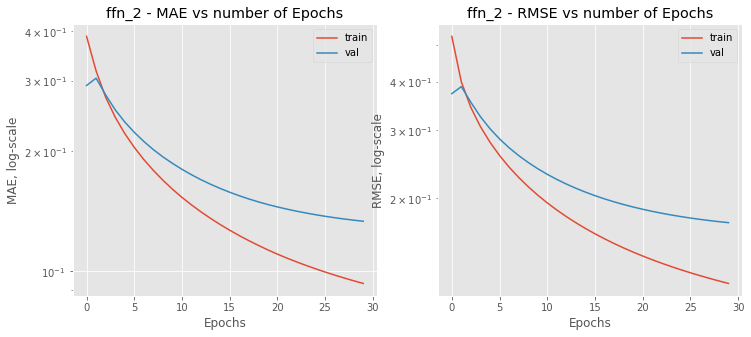

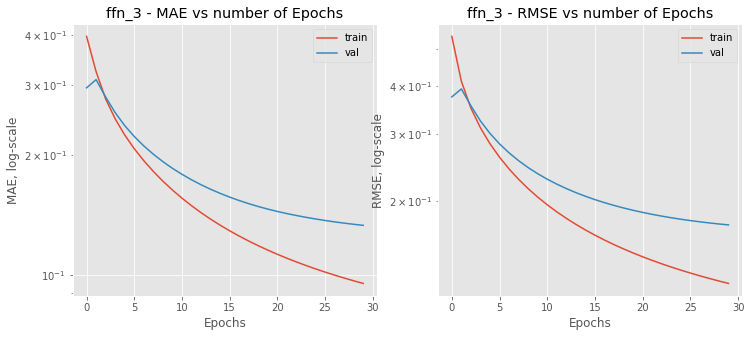

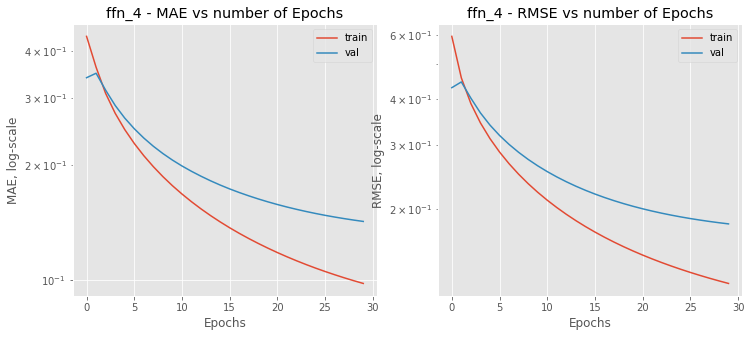

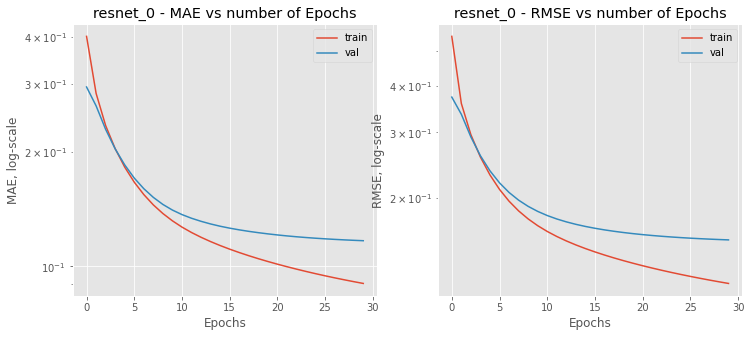

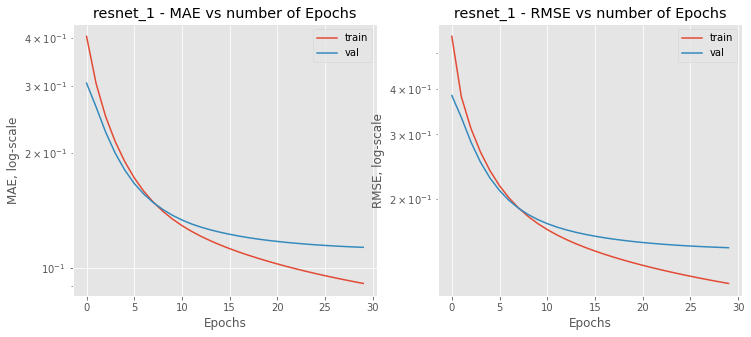

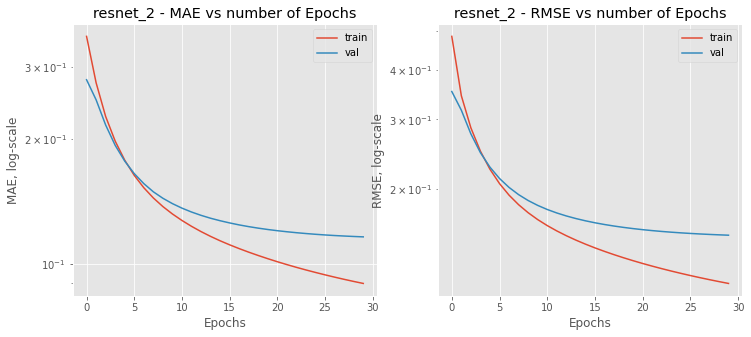

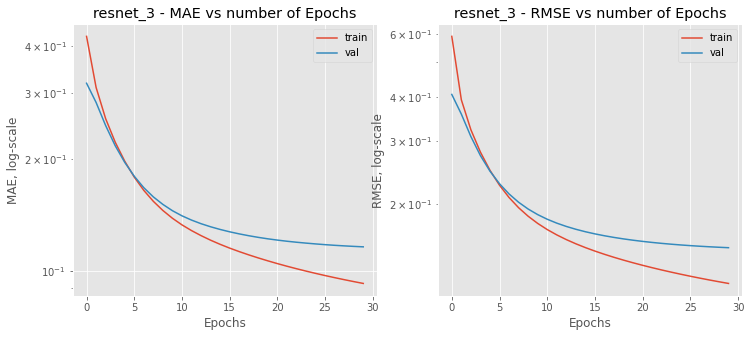

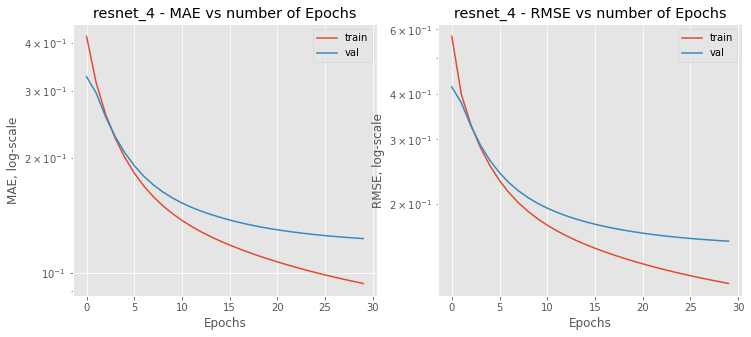

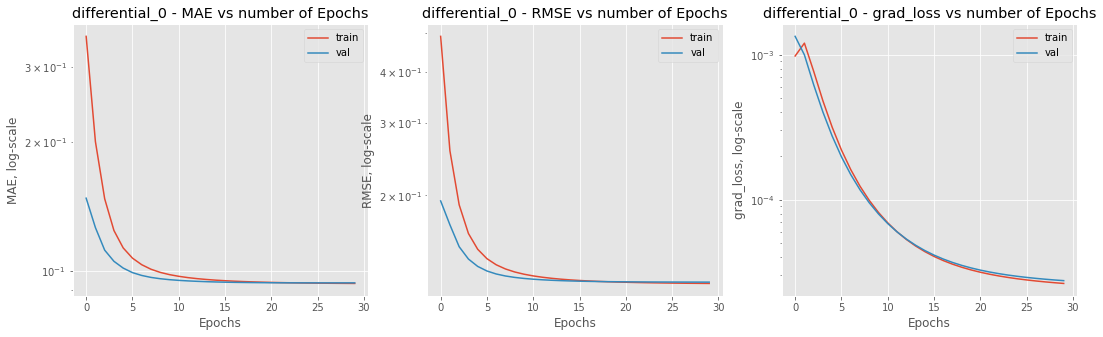

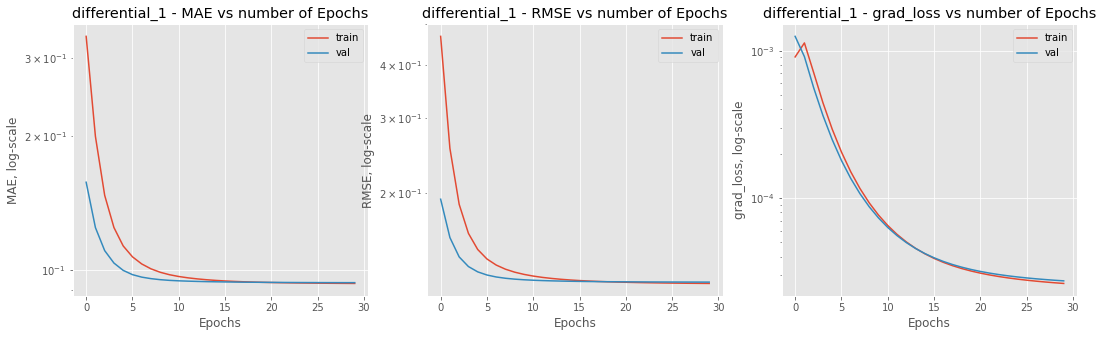

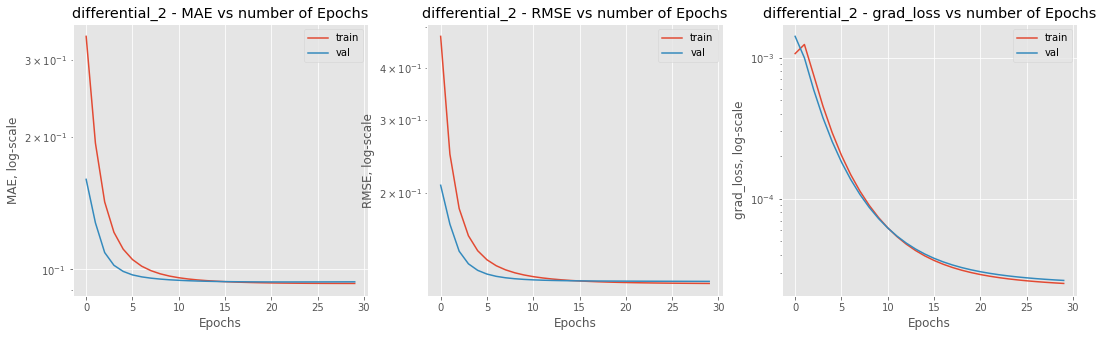

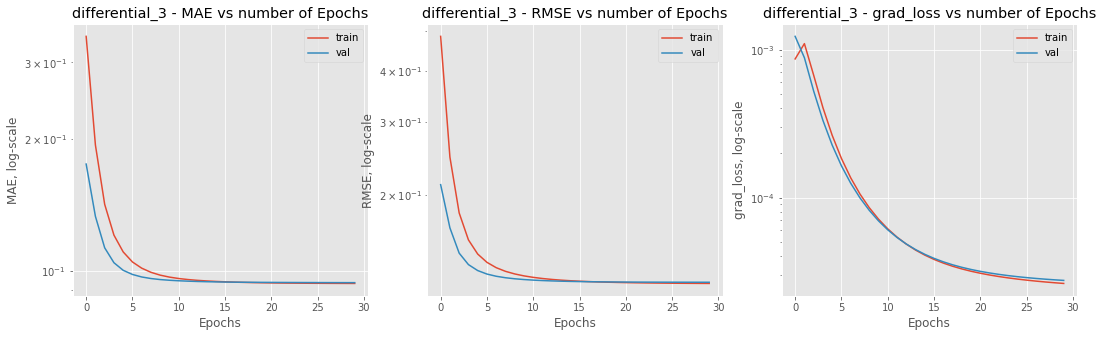

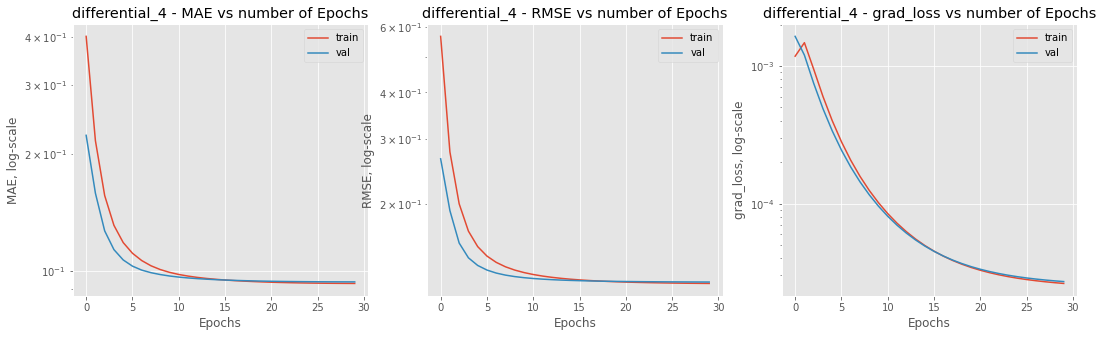

In [5]:
for METHOD_TYPE in ["control_var", "ffn", "resnet", "differential"]:
    for i in range(5):
        metrics_to_add = []
        opt = Adam(learning_rate=ExponentialDecay(LR, decay_steps=500,
            decay_rate=0.95,
        ))
        METHOD = f"{METHOD_TYPE}_{i}"
        nn_params2 = nn_params.copy()
        nn_params2["seed"] = 2022 + i
        if METHOD_TYPE == "resnet":
            nn_params2["resnet"] = True
        all_models[METHOD] = make_model(**nn_params2)
        if METHOD_TYPE == "differential":
            all_models[METHOD] = DifferentialModel(all_models[METHOD].input, all_models[METHOD].outputs)
            all_models[METHOD].set_params(lam = 10**6, grad_loss_fn = tf.keras.losses.MeanSquaredError())
            metrics_to_add = ["grad_loss"]
        if METHOD_TYPE == "control_var":
            nn_params2["output_act"] = "tanh"
            model2 = make_model(**nn_params2)
            intrinsic_val_layer = tf.keras.layers.Dense(1, activation='softplus', name='intrinsic_val_layer')(model2.layers[0].input)
            intrinsic_val_layer = tf.keras.layers.Dense(1, use_bias=False, name="scaling_layer")(intrinsic_val_layer)
            a = 10.0
            output_layer = Add()([model2.layers[-1].output, intrinsic_val_layer])
            all_models[METHOD] = Model(model2.inputs, output_layer)
            for x in all_models[METHOD].layers:
                if x.name == "intrinsic_val_layer":
                    x.set_weights([np.ones((N_ASSETS, 1)) / (N_ASSETS) * a, np.array([-a])])
                    x.trainable = False
                if x.name == "scaling_layer":
                    x.set_weights([np.array([[1.0 / a]])])
            # all_models[METHOD].layers[-3].set_weights([np.zeros(all_models[METHOD].layers[-3].get_weights()[0].shape), np.array([0.0])])
            
        all_models[METHOD].compile(optimizer=opt, **compile_params,  loss_weights=loss_weights)
        """
        Training
        """
        start = time.time()
        if METHOD_TYPE == "differential":
            train_time, history = train_nn(all_models[METHOD], Xs_train, (ys_train, grads_train), fit_params, metric_names + metrics_to_add, METHOD)   
        else:
            train_time, history = train_nn(all_models[METHOD], Xs_train, ys_train, fit_params, metric_names + metrics_to_add, METHOD)   

        start2 = time.time()
        with tf.GradientTape() as model_tape:
            output = all_models[METHOD](X_tensor)
            model_grads = model_tape.gradient(output, X_tensor)
        
        all_model_preds[METHOD] = output.numpy().reshape(-1)
        all_model_grads[METHOD] = model_grads.numpy()
        factor_grad = all_model_grads[METHOD].mean(axis = 1)
        inference_time = time.time() - start2

        temp = bachelier_eval_wrapper(
            X_df_test,
            X_df_test["call_analytic"].values,
            all_model_preds[METHOD],
            factor_grad,
            lower_bound=intrinsic_val,
            upper_bound=upper_bound,
            METHOD=METHOD,
            plots = []
        )
        temp["inference_time"] = inference_time
        temp["train_time"] = train_time
        temp["model_complexity"] = trainable_params(all_models[METHOD])
        all_res += [temp.copy()]
    
    
    display(tf.keras.utils.plot_model(
        all_models[METHOD], show_layer_activations=True, show_shapes=True, dpi=72
    ))

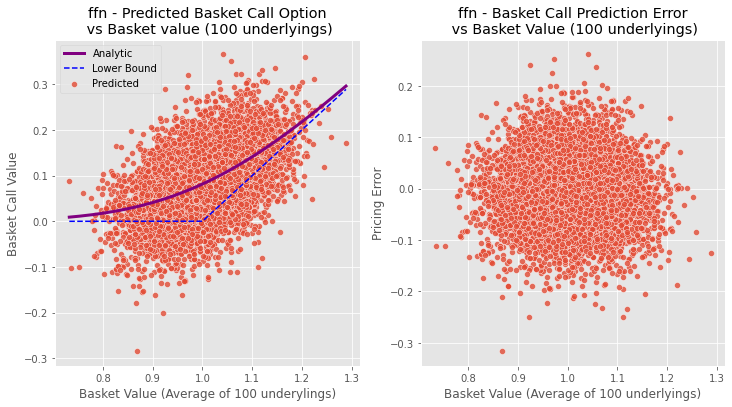

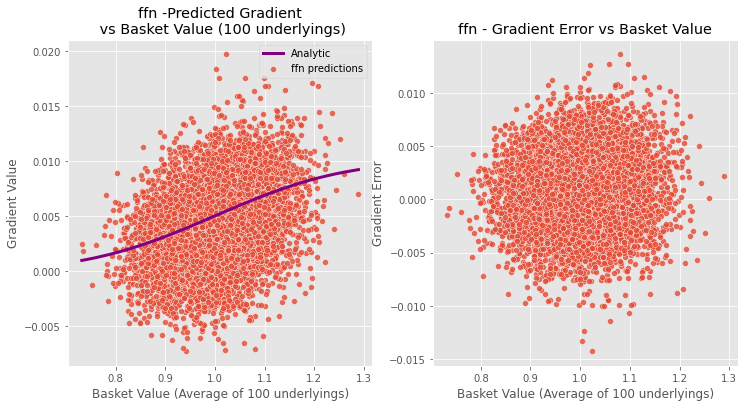

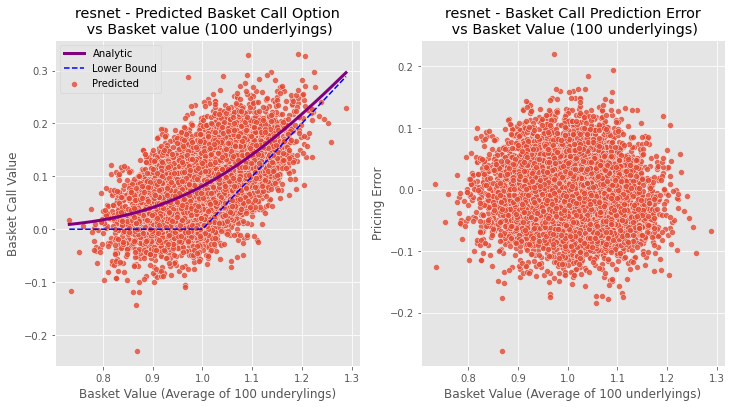

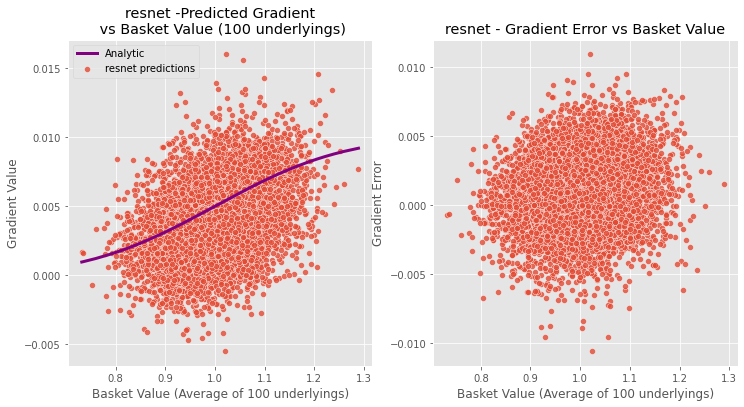

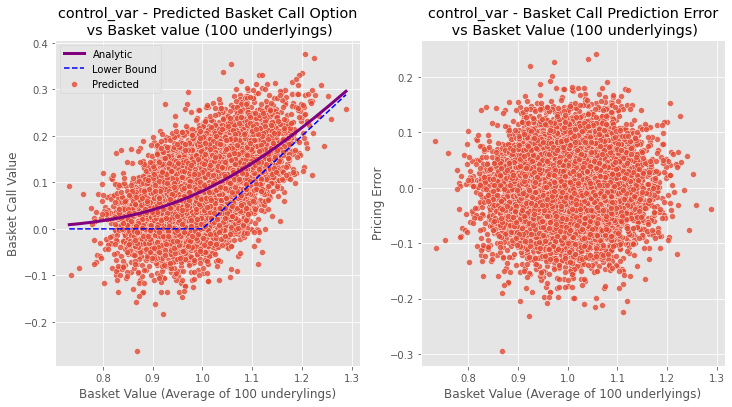

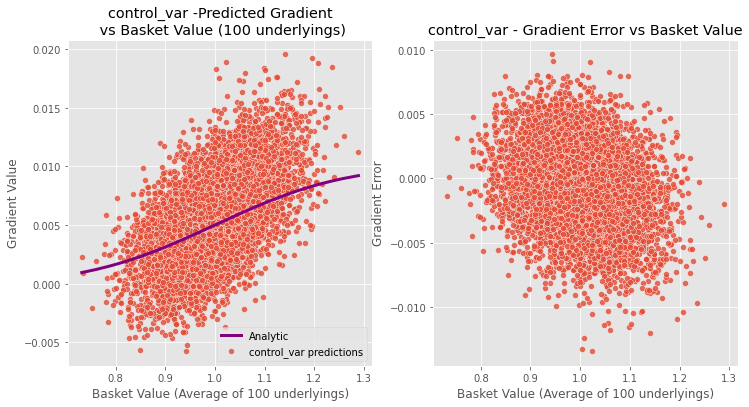

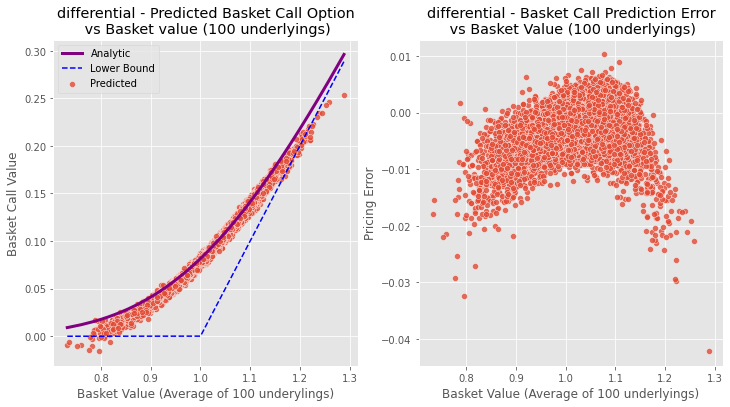

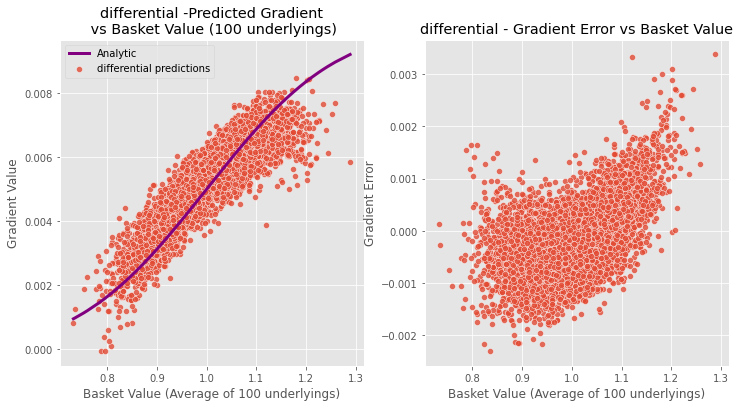

In [6]:
for METHOD in ["ffn", "resnet", "control_var", "differential"]:
    pred = pd.DataFrame({i: all_model_preds[f"{METHOD}_{i}"] for i in range(5)}).mean(axis = 1).values
    grad = pd.concat([pd.DataFrame({0: all_model_grads[f"{METHOD}_{i}"][:,j] for i in range(5)}).mean(axis = 1) for j in range(N_ASSETS)], axis = 1).values

    bachelier_eval_wrapper(
        X_df_test,
        X_df_test["call_analytic"].values,
        pred,
        grad.mean(axis = 1),
        lower_bound=intrinsic_val,
        upper_bound=upper_bound,
        METHOD=METHOD,
    )

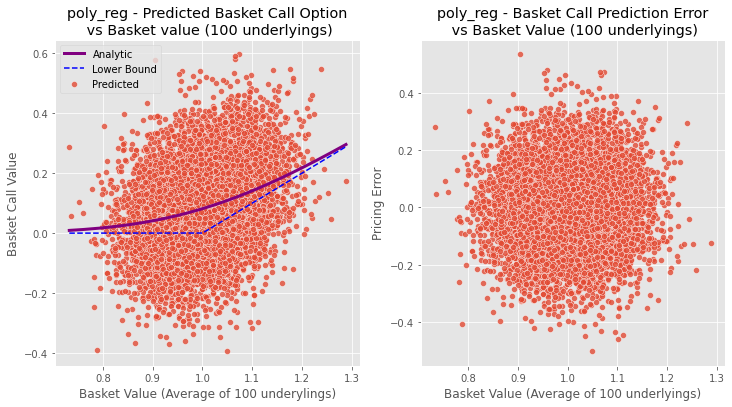

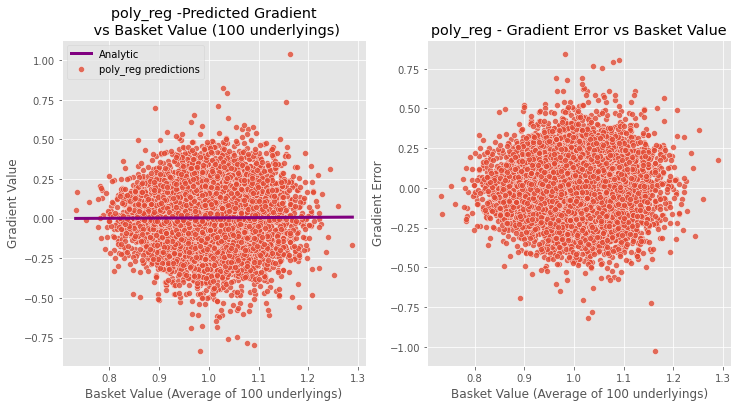

In [24]:
from nn_option_pricer.poly_reg import train_infer_poly
import math


METHOD = "poly_reg"
start = time.time()
degree = round((nn_params["hidden_units"]) ** (1/ N_FEATS))
degree = 2
# spline = SplineTransformer(n_knots=5, degree=10, knots="uniform", extrapolation="linear")
train_time, inference_time = train_infer_poly(degree, Xs_train, ys_train, Xs_test, ys_test, feat_names, all_models, all_model_preds, all_model_grads, all_model_hessian, f_to_i, moneyness_var="asset_0", METHOD="poly_reg", eps=1e-4)
temp = bachelier_eval_wrapper(
    X_df_test,
    X_df_test["call_analytic"].values,
    all_model_preds[METHOD],
    all_model_grads[METHOD].mean(axis = 1),
    lower_bound=intrinsic_val,
    upper_bound=upper_bound,
    METHOD=METHOD,
)

temp['train_time'] = train_time
temp["model_complexity"] = len(all_models[METHOD]['lr'].coef_)
temp['inference_time'] = inference_time
all_res += [temp.copy()]

## Monte Carlo (Pre-Computed)

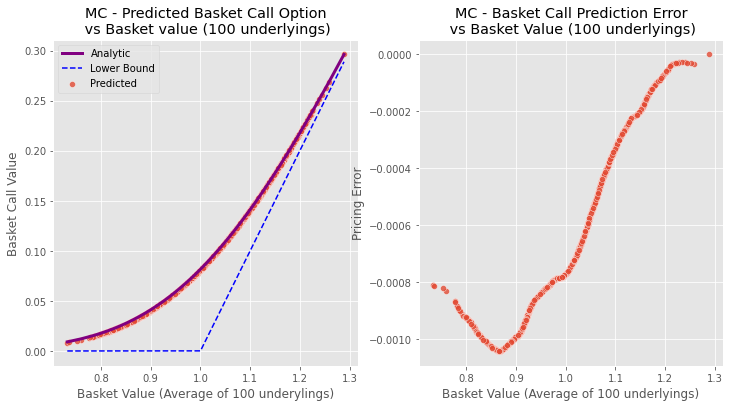

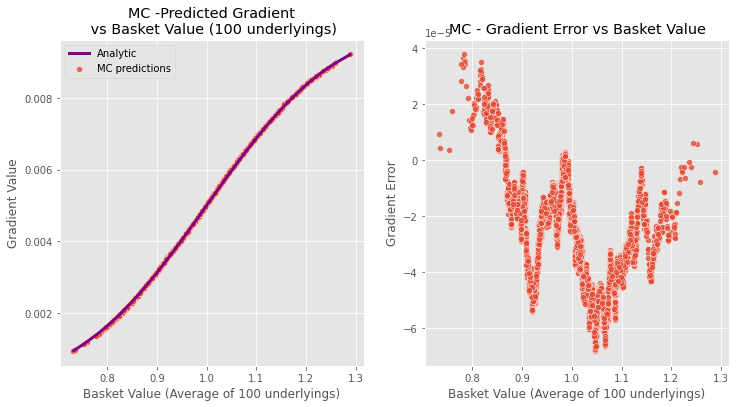

In [22]:
all_res += [
    bachelier_eval_wrapper(
        X_df_test,
        X_df_test["call_analytic_delta"].values,
        X_df_test["call_MC"].values,
        X_df_test["delta_MC"].values,
        lower_bound=intrinsic_val,
        upper_bound=upper_bound,
        METHOD="MC",
    )
]

## Results

In [90]:
res_df = (
    pd.concat(all_res)
    .reset_index()
    .drop_duplicates(subset=["index"], keep='last')
    .set_index("index")
    .T
)
res_df.loc["inference_time", "MC"] = 131.37
display(res_df.style.background_gradient(axis=1))
print(res_df.style.format("{:.5f}").to_latex())
res_df.to_csv("results/bachelier_long.csv")

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrr}
{index} & {control_var_0} & {control_var_1} & {control_var_2} & {control_var_3} & {control_var_4} & {ffn_0} & {ffn_1} & {ffn_2} & {ffn_3} & {ffn_4} & {resnet_0} & {resnet_1} & {resnet_2} & {resnet_3} & {resnet_4} & {differential_0} & {differential_1} & {differential_2} & {differential_3} & {differential_4} & {MC} & {poly_reg} \\
pred_l1 & 0.08838 & 0.08717 & 0.09279 & 0.09260 & 0.09983 & 0.09256 & 0.09152 & 0.09722 & 0.09738 & 0.10603 & 0.06986 & 0.06773 & 0.07364 & 0.07321 & 0.07697 & 0.00564 & 0.00556 & 0.00531 & 0.00525 & 0.00517 & 0.00070 & 0.10229 \\
pred_l2 & 0.11306 & 0.11191 & 0.11821 & 0.11787 & 0.12724 & 0.11928 & 0.11809 & 0.12450 & 0.12471 & 0.13604 & 0.09012 & 0.08703 & 0.09383 & 0.09364 & 0.09842 & 0.00738 & 0.00744 & 0.00692 & 0.00711 & 0.00680 & 0.00074 & 0.12916 \\
pred_l_inf & 0.50382 & 0.49414 & 0.48898 & 0.52245 & 0.51203 & 0.58864 & 0.56379 & 0.56298 & 0.62966 & 0.61478 & 0.54278 & 0.42931 & 0.52664 & 0.52733 & 0.52243 & 0.0

In [82]:
res_df2

control_var           ffn  differential  \
pred_l1                         0.092154      0.096942      0.005386   
pred_l2                         0.117660      0.124523      0.007128   
pred_l_inf                      0.504285      0.591969      0.049982   
pred_lower_bound_violation      0.310880      0.318240      0.006280   
grad_l1                         0.002275      0.002820      0.000604   
grad_l2                         0.002883      0.003531      0.000762   
grad_l_inf                      0.012922      0.014813      0.004639   
grad_lower_bound_violation      0.056220      0.124620      0.000040   
inference_time                  0.072880      0.063374      0.067388   
train_time                     15.636594     15.140941     18.092965   
model_complexity            20902.000000  20901.000000  20901.000000   

                                  resnet     poly_reg          MC  total_time  
pred_l1                         0.072280     0.102290    0.000703         NaN  
pred_l2                         0.092609     0.129159    0.000735         NaN  
pred_l_inf                      0.509698     0.535222    0.001041         NaN  
pred_lower_bound_violation      0.264860     0.321600    0.000000         NaN  
grad_l1                         0.002257     0.134554    0.000030         NaN  
grad_l2                         0.002816     0.172429    0.000034         NaN  
grad_l_inf                      0.011299     1.026712    0.000068         NaN  
grad_lower_bound_violation      0.055140     0.486000    0.000000         NaN  
inference_time                  0.074499    52.412841  131.370000         NaN  
train_time                     16.511094    22.910832         NaN         NaN  
model_complexity            20901.000000  5151.000000         NaN         NaN

In [93]:
res_df2 = pd.concat(
    [
        res_df[[f"control_var_{i}" for i in range(5)]].mean(axis=1),
        res_df[[f"ffn_{i}" for i in range(5)]].mean(axis=1),
        res_df[[f"differential_{i}" for i in range(5)]].mean(axis=1),
        res_df[[f"resnet_{i}" for i in range(5)]].mean(axis=1),
        res_df[['poly_reg']],
        res_df["MC"],
    ],
    axis=1,
)
res_df2.columns = ["control_var", "ffn", "differential", "resnet", "poly_reg","MC"]
res_df2 =pd.concat([res_df2, pd.DataFrame((res_df2.T['train_time'].fillna(0) + res_df2.T['inference_time'].fillna(0)), columns=['total_time']).T])
display(res_df2.style.background_gradient(axis=1))
print(res_df2.to_latex(float_format="%.3e", bold_rows=True))
res_df2.to_csv("results/bachelier_short.csv")

\begin{tabular}{lrrrrrr}
\toprule
{} &  control\_var &       ffn &  differential &    resnet &  poly\_reg &        MC \\
\midrule
\textbf{pred\_l1                   } &    9.215e-02 & 9.694e-02 &     5.386e-03 & 7.228e-02 & 1.023e-01 & 7.031e-04 \\
\textbf{pred\_l2                   } &    1.177e-01 & 1.245e-01 &     7.128e-03 & 9.261e-02 & 1.292e-01 & 7.353e-04 \\
\textbf{pred\_l\_inf                } &    5.043e-01 & 5.920e-01 &     4.998e-02 & 5.097e-01 & 5.352e-01 & 1.041e-03 \\
\textbf{pred\_lower\_bound\_violation} &    3.109e-01 & 3.182e-01 &     6.280e-03 & 2.649e-01 & 3.216e-01 & 0.000e+00 \\
\textbf{grad\_l1                   } &    2.275e-03 & 2.820e-03 &     6.036e-04 & 2.257e-03 & 1.346e-01 & 3.017e-05 \\
\textbf{grad\_l2                   } &    2.883e-03 & 3.531e-03 &     7.623e-04 & 2.816e-03 & 1.724e-01 & 3.437e-05 \\
\textbf{grad\_l\_inf                } &    1.292e-02 & 1.481e-02 &     4.639e-03 & 1.130e-02 & 1.027e+00 & 6.816e-05 \\
\textbf{grad\_lower\_bound\_viola

In [58]:
display(res_df2.drop('MC', axis = 1).style.background_gradient(axis=1))

In [51]:
res_df2.to_latex?

Signature:
res_df2.to_latex(
    buf=None,
    columns=None,
    col_space=None,
    header=True,
    index=True,
    na_rep='NaN',
    formatters=None,
    float_format=None,
    sparsify=None,
    index_names=True,
    bold_rows=False,
    column_format=None,
    longtable=None,
    escape=None,
    encoding=None,
    decimal='.',
    multicolumn=None,
    multicolumn_format=None,
    multirow=None,
    caption=None,
    label=None,
    position=None,
)
Docstring:
Render object to a LaTeX tabular, longtable, or nested table/tabular.

Requires ``\usepackage{booktabs}``.  The output can be copy/pasted
into a main LaTeX document or read from an external file
with ``\input{table.tex}``.

.. versionchanged:: 1.0.0
   Added caption and label arguments.

.. versionchanged:: 1.2.0
   Added position argument, changed meaning of caption argument.

Parameters
----------
buf : str, Path or StringIO-like, optional, default None
    Buffer to write to. If None, the output is returned as a string.


$\frac{\partial^{2} g}{\partial x^{2}} =  \frac{1}{N_{F}^{2}}\frac{\partial}{\partial s} \sum_{j = 1}^{N_{F}} \sum_{i = 1}^{N_{F}} \frac{\partial^{2} g}{\partial s_{i} \partial s_{j}}$

Time to compute Hessian: (s): 14.735913753509521


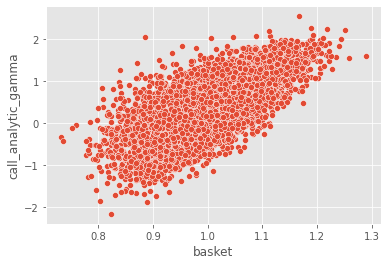

In [11]:
from scipy.linalg import cholesky

SEED = 42
rng = default_rng(SEED)

"""
Define Parameters
"""
N_ASSETS = 100
F = N_ASSETS
N_SAMPLES = 10**4
T = 1.0
K = 1.0

# # Covariance matrix
L = 0.2 * rng.standard_normal((N_ASSETS, F))
cov = L @ L.T
assert np.linalg.det(cov) > 0
L = cholesky(cov)
start = time.time()
with tf.GradientTape() as tape2:
    with tf.GradientTape() as model_tape:
        output = all_models["differential_4"](X_tensor)
    model_grads = model_tape.gradient(output, X_tensor)
jacobian = tape2.batch_jacobian(model_grads, X_tensor)
# j_sum = tf.reduce_sum(jacobian, axis=2)
hessian_det = tf.linalg.trace(L.T @ jacobian @ L)
factor_grad = tf.math.reduce_mean(model_grads, axis=1).numpy()
j_sum = tf.reduce_sum(tf.reduce_sum(jacobian, axis=2), axis = 1)
sns.scatterplot(X_df_test['basket'], X_df_test['call_analytic_gamma'] - j_sum)
# sns.scatterplot(X_df_test["basket"], hessian_det)
end = time.time()
print("Time to compute Hessian: (s):", end - start)

In [12]:
hessian_det = tf.linalg.trace(L @ jacobian @ L.T)
hessian_det

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([ 0.12114332,  0.02068772, -0.11603032, ...,  0.11849238,
       -0.07128207, -0.1557158 ], dtype=float32)>

In [123]:
j_sum

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([2.3868308 , 1.6440675 , 0.7802936 , ..., 2.2175512 , 1.5894762 ,
       0.21223323], dtype=float32)>

<AxesSubplot:xlabel='basket', ylabel='call_analytic_delta'>

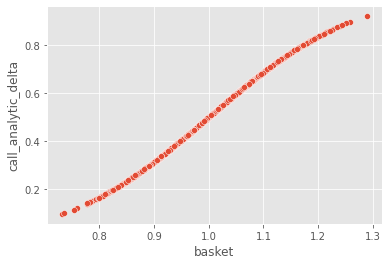

In [96]:
sns.scatterplot(X_df_test['basket'], X_df_test['call_analytic_delta'])

<AxesSubplot:xlabel='basket', ylabel='call_analytic_delta'>

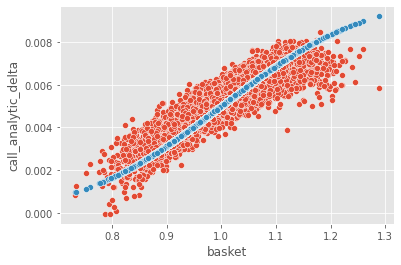

In [14]:
sns.scatterplot(X_df_test['basket'], factor_grad)
sns.scatterplot(X_df_test['basket'],  X_df_test['call_analytic_delta'] / N_ASSETS)

In [101]:
idx = X_df_test['basket'].sort_values().index

In [117]:
X_df_test['basket'].drop_duplicates()

0       0.903803
1       1.018261
2       1.084053
3       0.908282
4       1.087180
          ...   
9995    0.972591
9996    0.882019
9997    0.926329
9998    1.045206
9999    1.112908
Name: basket, Length: 10000, dtype: float64

<AxesSubplot:xlabel='basket'>

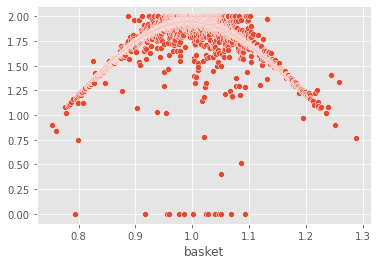

In [122]:
sns.scatterplot(X_df_test['basket'].iloc[idx], (X_df_test['call_analytic_delta'].iloc[idx].diff(1).diff(1) / X_df_test['basket'].iloc[idx].diff(1).diff(1)).clip(0, 2))

<AxesSubplot:xlabel='basket', ylabel='call_analytic_gamma'>

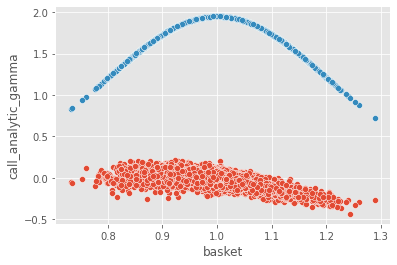

In [15]:
sns.scatterplot(X_df_test['basket'], hessian_det)
sns.scatterplot(X_df_test['basket'], X_df_test['call_analytic_gamma'])

In [16]:
# if METHOD_TYPE == "control_var":
#     nn_params2["output_act"] = "tanh"
#     model2 = make_model(**nn_params2)
#     intrinsic_val_layer = tf.keras.layers.Dense(1, activation='softplus', name='intrinsic_val_layer')(model2.layers[0].input)
#     intrinsic_val_layer = tf.keras.layers.Dense(1, use_bias=False, name="scaling_layer")(intrinsic_val_layer)
#     a = 10.0
#     output_layer = Add()([model2.layers[-1].output, intrinsic_val_layer])
#     all_models[METHOD] = Model(model2.inputs, output_layer)
#     for x in all_models[METHOD].layers:
#         if x.name == "intrinsic_val_layer":
#             x.set_weights([np.ones((N_ASSETS, 1)) / (N_ASSETS) * a, np.array([-a])])
#             x.trainable = False
#         if x.name == "scaling_layer":
#             x.set_weights([np.array([[1.0 / a]])])
#             # x.set_weights([np.array([[0.0]])])
#             # x.trainable = False
#     # all_models[METHOD].layers[-3].set_weights([np.zeros(all_models[METHOD].layers[-3].get_weights()[0].shape), np.array([0.0])])

# all_models[METHOD].compile(optimizer=opt, **compile_params,  loss_weights=loss_weights)

In [17]:
# start = time.time()
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X2 = scaler.fit_transform(Xs_train[ys_train > 0])

# gpr = GaussianProcessRegressor().fit(X2, ys_train[ys_train > 0])
# train_time = time.time() - start
# start = time.time()
# preds = gpr.predict(scaler.transform(Xs_train))
# inference_time = time.time() - start
# train_time, inference_time
# sns.scatterplot(X_df_test['basket'], preds)